## X-TBWISA: Explainable Transformer-based What-if Scenario Generation (SHAP + IG)

This notebook is a *drop-in sequel experiment* to **TBWISA** ("Generating and Optimizing What-If Scenarios Using a Transformers-Based Forecasting Model"):
- **TBWISA core**: SCM elasticity → stochastic counterfactuals → transformer forecasting → optimal revenue window.
- **X-TBWISA extension**: next-step **surrogate explainer** (XGBoost) + **SHAP** attributions + **Integrated Gradients** on the transformer + **explanation stability** and **economic alignment** checks.

> Notes:
> - Paths and naming conventions follow the existing notebooks (`datasets/`, `trained-models/`).
> - The surrogate target is **next-step demand** (teacher = transformer demand model).


What it includes (end-to-end):

1. Loads datasets/aws_ce_dataset.csv and filters by store_id, item_id

1. Loads or trains ImprovedTransformerForecasting models into trained-models/transformer-<dataset>-improved-<col>.joblib

1. TBWISA scenario generation (TBWISAGenerator.generate_scenarios + apply_scenarios)

1. Revenue computation + TBWISA optimal window selection

1. Surrogate dataset builder: features = d_lag_1..d_lag_seq_len + delta + last_price, label = transformer next-step demand

1. Trains XGBoost surrogate + TreeSHAP

1. Local SHAP per delta at “decision-point” (last window)

1. Integrated Gradients directly on the transformer (next-step)

1. Plots tying SHAP stability ↔ monotonicity and economic plausibility + SHAP(delta) alignment checks

1. Saves CSV artifacts to outputs_x_tbwisa/

In [1]:
import os
import joblib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (used in existing notebooks)
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Explainability
import shap
import xgboost as xgb

# Deep explainability (Integrated Gradients)
import tensorflow as tf

# Local imports: keep consistent with your repo layout
try:
    from source.tbwisa import TBWISAGenerator
except Exception:
    from tbwisa import TBWISAGenerator

try:
    from source.improved_transformer_forecasting import ImprovedTransformerForecasting
except Exception:
    from improved_transformer_forecasting import ImprovedTransformerForecasting


/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. Config parameters

In [2]:
# Dataset specific parameters
dataset_name = 'awsce'                               # Dataset name
input_col = 'price'                                  # Independent variable column
output_col = 'demand'                                # Dependent variable column
result_col = 'revenue'                               # Objective result column

item_id = "item_281"                                 # Item used for single-item analysis
# item_id = "item_100"                                 
store_id = "store_001"                               # Store filter (AWS CE dataset)

forecast_length = 6                                  # Forecast horizon (months in current TBWISA implementation)
test_size = 0.2                                      # Train/test split ratio for optional batch eval

# Scenario parameters
min_window_size = 2
max_window_size = 6
price_change_percentages = [-15, -10, -5, 5, 10, 15]  # Intervention grid (δ)

# Transformer parameters (match existing notebooks)
sequence_length = 30
num_layers = 4
size_layer = 128
embedded_size = 128
epochs = 500
dropout_rate = 0.2
learning_rate = 1e-4
batch_size = 64

# Explainability parameters (X-TBWISA)
SURROGATE_MAX_SAMPLES = 6000       # total training rows for surrogate
SURROGATE_STRIDE = 1               # sampling stride over time
SHAP_BACKGROUND_SIZE = 300         # rows for TreeExplainer background
SHAP_EXPLAIN_SAMPLES = 250         # rows for global SHAP summary
IG_STEPS = 64                      # integrated gradients steps

# Plot parameters
plot_font_size = 14
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = plot_font_size

# I/O paths
DATA_PATH = "datasets/aws_ce_dataset.csv"
MODEL_DIR = "trained-models"
os.makedirs(MODEL_DIR, exist_ok=True)


#### 2. Load data

In [3]:
# AWS Consumer Electronics Dataset (expected format from your existing notebooks)
df = pd.read_csv(DATA_PATH, index_col="timestamp", parse_dates=True)

# Filter by store first (matches previous notebook approach)
df = df[df["store_id"] == store_id].copy()
df.sort_index(inplace=True)

# Single-item slice (keeps notebook interactive)
data_full = df[(df["item_id"] == item_id) & (df["store_id"] == store_id)].copy()

# For scenario generation and forecasting, your original notebook removes the last forecast_length rows
data = data_full.iloc[:-forecast_length].copy()
data_test = data_full.iloc[-forecast_length-1:].copy()  # includes last actual + horizon

display(data.head(), data.tail(), data_test.head(), data_test.tail())
print("History length:", len(data), "| Test slice:", len(data_test))


,item_id,store_id,demand,price
timestamp,,,,
2017-10-01,item_281,store_001,306.197375,91.000000
2017-11-01,item_281,store_001,236.071227,107.654509
2017-12-01,item_281,store_001,233.393487,107.654509
2018-01-01,item_281,store_001,230.650446,107.654509
2018-02-01,item_281,store_001,228.577099,107.654509


,item_id,store_id,demand,price
timestamp,,,,
2018-11-01,item_281,store_001,239.136259,106.732654
2018-12-01,item_281,store_001,416.408490,73.183245
2019-01-01,item_281,store_001,312.838094,87.859488
2019-02-01,item_281,store_001,372.119737,77.791515
2019-03-01,item_281,store_001,370.739042,77.791515


,item_id,store_id,demand,price
timestamp,,,,
2019-03-01,item_281,store_001,370.739042,77.791515
2019-04-01,item_281,store_001,340.182085,82.528550
2019-05-01,item_281,store_001,343.005258,82.528550
2019-06-01,item_281,store_001,346.994684,82.528550
2019-07-01,item_281,store_001,351.081399,82.528550


,item_id,store_id,demand,price
timestamp,,,,
2019-05-01,item_281,store_001,343.005258,82.52855
2019-06-01,item_281,store_001,346.994684,82.52855
2019-07-01,item_281,store_001,351.081399,82.52855
2019-08-01,item_281,store_001,354.170372,82.52855
2019-09-01,item_281,store_001,355.433914,82.52855


History length: 18 | Test slice: 7


---
### 3. Model Construction
#### 3.1. Load or train transformer models

In [4]:
def load_or_train_transformer_model(df_train: pd.DataFrame, col: str, dataset_name: str):
    """Load a trained ImprovedTransformerForecasting model (joblib dict) or train and save it."""
    model_file_path = os.path.join(MODEL_DIR, f"transformer-{dataset_name}-improved-{col}.joblib")

    model = ImprovedTransformerForecasting(
        sequence_length=sequence_length,
        size_layer=size_layer,
        embedded_size=size_layer,
        output_size=1,
        dropout_rate=dropout_rate
    )

    if os.path.exists(model_file_path):
        print(f"Loading trained model -> {model_file_path}")
        data_obj = joblib.load(model_file_path)
        model.model = data_obj["model"]
        model.scaler = data_obj["scaler"]
        # Prefer stored sequence_length if present (keeps compatibility)
        if "sequence_length" in data_obj and data_obj["sequence_length"] is not None:
            model.sequence_length = int(data_obj["sequence_length"])
        return model

    print(f"Trained model not found -> training new model -> {model_file_path}")
    train_arr = df_train[col].dropna().values.astype(np.float32)

    model.train(train_arr, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)

    joblib.dump(
        {"model": model.model, "scaler": model.scaler, "sequence_length": model.sequence_length},
        model_file_path
    )
    print("Model trained and saved successfully.")
    return model

# Load existing store-level models if present; otherwise train on the store-filtered dataset (matches your prior notebooks).
model_input = load_or_train_transformer_model(df, input_col, dataset_name)
model_output = load_or_train_transformer_model(df, output_col, dataset_name)


Loading trained model -> trained-models/transformer-awsce-improved-price.joblib
Loading trained model -> trained-models/transformer-awsce-improved-demand.joblib


#### 3.2. Baseline forecast (price + demand)

In [5]:
# Baseline price forecast
predicted_input = model_input.forecast(data[input_col].values, forecast_length)
baseline_input = pd.DataFrame(data[[input_col]].iloc[-forecast_length:])
baseline_input[input_col] = predicted_input
baseline_input.index = baseline_input.index + pd.DateOffset(months=forecast_length)
baseline_input.loc[data.index[-1]] = data[input_col].iloc[-1]
baseline_input.sort_index(inplace=True)

# Baseline demand forecast
predicted_output = model_output.forecast(data[output_col].values, forecast_length)
baseline_output = pd.DataFrame(data[[output_col]].iloc[-forecast_length:])
baseline_output[output_col] = predicted_output
baseline_output.index = baseline_output.index + pd.DateOffset(months=forecast_length)
baseline_output.loc[data.index[-1]] = data[output_col].iloc[-1]
baseline_output.sort_index(inplace=True)

display(baseline_input.head(), baseline_output.head())


,price
timestamp,
2019-03-01,77.791515
2019-04-01,82.498109
2019-05-01,86.461316
2019-06-01,89.803714
2019-07-01,92.226136


,demand
timestamp,
2019-03-01,370.739042
2019-04-01,349.183440
2019-05-01,326.537132
2019-06-01,313.574848
2019-07-01,302.566066


---
### 4. TBWISA Scenario Generation + Forecasting
#### 4.1 Generate SCM counterfactual scenarios

In [6]:
scenario_generator = TBWISAGenerator()

# Raw counterfactual scenario series (same index as `data`)
scenarios_input_raw, scenarios_output_raw = scenario_generator.generate_scenarios(
    data, input_col, output_col, price_change_percentages
)

print("Scenarios:", list(scenarios_output_raw.keys()))


Scenarios: ['price change -15%', 'price change -10%', 'price change -5%', 'price change 5%', 'price change 10%', 'price change 15%']


#### 4.2 Apply forecasting to scenarios (price + demand)

In [7]:
# Forecast price under each scenario
scenarios_input = scenario_generator.apply_scenarios(
    data, scenarios_input_raw, input_col, model=model_input, forecast_horizon=forecast_length
)
scenarios_input["Baseline"] = baseline_input
scenarios_input["Actuals"] = data_test[[input_col]]

# Forecast demand under each scenario
scenarios_output = scenario_generator.apply_scenarios(
    data, scenarios_output_raw, output_col, model=model_output, forecast_horizon=forecast_length
)
scenarios_output["Baseline"] = baseline_output
scenarios_output["Actuals"] = data_test[[output_col]]

# Preview one scenario
key0 = list(scenarios_output.keys())[0]
display(scenarios_input[key0].head(), scenarios_output[key0].head())


/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ trea

,price
timestamp,
2019-03-01,77.791515
2019-04-01,81.514582
2019-05-01,85.804249
2019-06-01,88.983901
2019-07-01,90.979804


,demand
timestamp,
2019-03-01,370.739042
2019-04-01,449.512434
2019-05-01,394.467850
2019-06-01,350.542842
2019-07-01,311.940663


#### 4.3 Compute revenue per scenario + optimal window

In [8]:
# Compute historical revenue
data[result_col] = data[input_col] * data[output_col]

# Compute scenario revenues
scenarios_result = {}
total_revenue = {}

for scenario_name, demand_df in scenarios_output.items():
    # Skip if price not available
    price_df = scenarios_input.get(scenario_name)
    if price_df is None:
        continue

    # Align by index (both include last actual + forecast)
    aligned = demand_df.join(price_df, how="inner")
    revenue_df = (aligned[output_col] * aligned[input_col]).to_frame(name=result_col)

    scenarios_result[scenario_name] = revenue_df
    total_revenue[scenario_name] = float(revenue_df.sum().values[0])

# Find optimal window (TBWISA core)
optimal_window = scenario_generator.find_optimal_window_with_demand(
    scenarios_result,
    scenarios_output,
    penalty_factor=0.1,
    demand_weight=1.5,
    min_window_size=min_window_size,
    max_window_size=max_window_size
)

print(f"Optimal scenario: {optimal_window['scenario']}")
print(f"Window: {optimal_window['start']} to {optimal_window['end']}")
print(f"Score: {optimal_window['score']:.4f}")


Optimal scenario: price change -15%
Window: 1 to 2
Score: 35244.3098


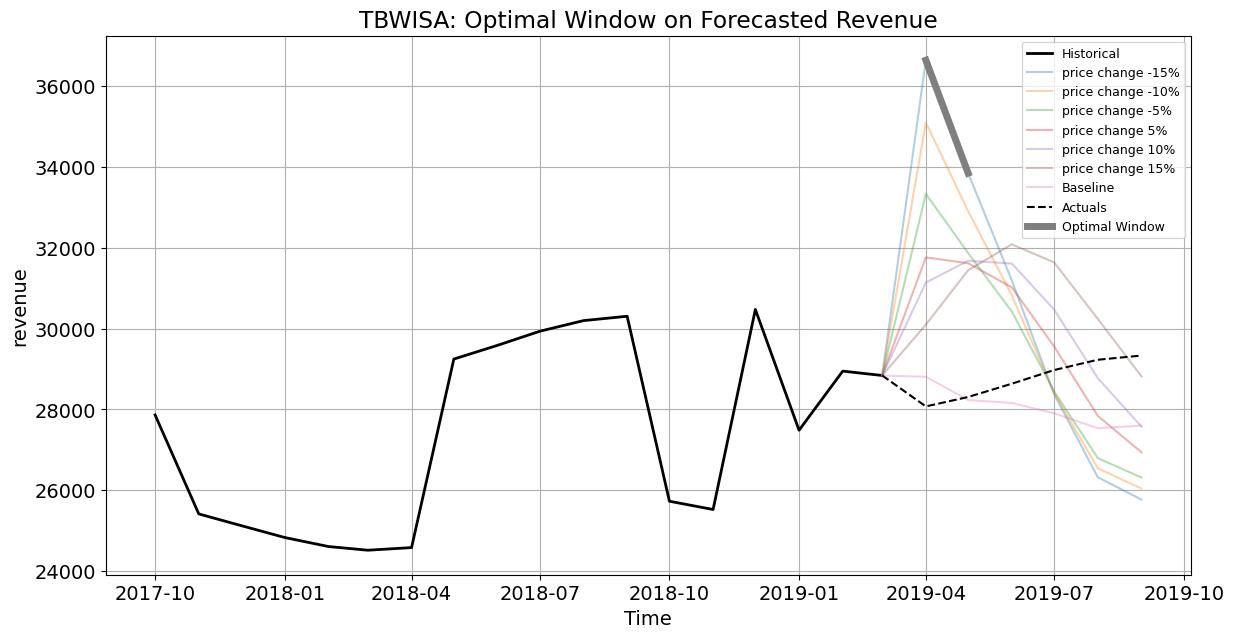

In [9]:
def plot_optimal_window(original_series, forecasted_result, optimal):
    """Plot historical + forecasted revenue and highlight the optimal window."""
    if optimal["scenario"] is None:
        print("No optimal window found.")
        return

    plt.figure(figsize=(14, 7))

    # Historical revenue
    plt.plot(original_series.index, original_series.values, label="Historical", color="black", linewidth=2)

    # Forecasted revenue per scenario
    for scenario, series in forecasted_result.items():
        if isinstance(series, pd.DataFrame):
            series = series.iloc[:, 0]
        if scenario == "Actuals":
            plt.plot(series.index, series.values, label=f"{scenario}", color="black", linestyle="--")
        else:
            plt.plot(series.index, series.values, alpha=0.35, label=scenario)

    # Highlight optimal window on the chosen scenario
    best_series = forecasted_result[optimal["scenario"]]
    if isinstance(best_series, pd.DataFrame):
        best_series = best_series.iloc[:, 0]

    start_i, end_i = optimal["start"], optimal["end"]
    if start_i is not None and end_i is not None:
        w_idx = best_series.index[start_i:end_i+1]
        w_val = best_series.values[start_i:end_i+1]
        plt.plot(w_idx, w_val, linewidth=5, label="Optimal Window")

    plt.title("TBWISA: Optimal Window on Forecasted Revenue")
    plt.xlabel("Time")
    plt.ylabel(result_col)
    plt.legend(loc="best", fontsize=9)
    plt.grid(True)
    plt.show()

plot_optimal_window(data[result_col], scenarios_result, optimal_window)


---
### 5. X-TBWISA Explainability
#### 5.1 Build surrogate dataset (target = transformer next-step demand)

In [10]:
def _as_1d(a):
    return np.asarray(a, dtype=np.float32).reshape(-1)

def _get_values(x):
    # accepts pandas Series or numpy
    return _as_1d(x.values if hasattr(x, "values") else x)

def prep_window_for_model(model: ImprovedTransformerForecasting, window_raw: np.ndarray) -> np.ndarray:
    """Pad/truncate to make the window usable for the transformer and its scaler."""
    w = _as_1d(window_raw)

    # Model can accept variable-length sequences (Input shape=(None, 1)),
    # but we keep a consistent prep policy for reproducibility.
    if model.sequence_length is None:
        return w

    seq_len = int(model.sequence_length)

    if w.size == 0:
        raise ValueError("Empty window passed to model.")

    if w.size < seq_len:
        pad = np.repeat(w[[0]], seq_len - w.size)
        w = np.concatenate([pad, w])
    elif w.size > seq_len:
        w = w[-seq_len:]

    return w

def transformer_next_step_from_window(model: ImprovedTransformerForecasting, window_raw: np.ndarray) -> float:
    """Next-step demand prediction (teacher) from a raw window (any length)."""
    w = prep_window_for_model(model, window_raw)

    # Fast path: use internal scaler + model directly
    try:
        x = model.scaler.transform(w.reshape(-1, 1)).astype(np.float32)
        x = x.reshape(1, x.shape[0], 1)  # variable time length is allowed
        pred_scaled = model.model.predict(x, verbose=0).astype(np.float32)
        pred = model.scaler.inverse_transform(pred_scaled)[0, 0]
        return float(pred)
    except Exception:
        # Fallback: call forecast() for one step (will pad internally)
        return float(model.forecast(w, forecast_length=1)[0])

def build_surrogate_dataset_from_scenarios(
    data: pd.DataFrame,
    scenarios_input_raw: dict,
    scenarios_output_raw: dict,
    price_change_percentages: list,
    model_output: ImprovedTransformerForecasting,
    max_samples: int = 6000,
    stride: int = 3,
    seed: int = 42,
    seq_len_override: int = None
):
    """Build (X, y) where y = transformer next-step demand, X = lags + delta + last_price.

    Robust to:
      - missing scenarios
      - short time series (auto-reduces surrogate lag length)
      - transformer sequence_length > series length (pads for teacher prediction)
    """
    rng = np.random.default_rng(seed)

    # Determine available scenario keys
    available = []
    lengths = {}
    for delta in price_change_percentages:
        sname = f"{input_col} change {delta}%"
        if sname in scenarios_output_raw and sname in scenarios_input_raw:
            d_s = _get_values(scenarios_output_raw[sname])
            p_s = _get_values(scenarios_input_raw[sname])
            lengths[sname] = (len(d_s), len(p_s))
            available.append(delta)

    if len(available) == 0:
        raise ValueError(
            "No matching scenarios found. " 
            f"Expected keys like '{input_col} change -10%'. " 
            f"Available keys: {list(scenarios_output_raw.keys())[:10]}"
        )

    # Effective surrogate lag length:
    min_len = min(lengths[f"{input_col} change {d}%"][0] for d in available)

    # Heuristic: pick a lag length that yields enough windows even on short series.
    # With series length L, number of windows per scenario ≈ (L - seq_len + 1) / stride.
    # We target at least `min_windows` windows when possible.
    min_windows = 10
    max_seq_for_windows = max(5, min_len - (min_windows - 1))

    if seq_len_override is not None:
        seq_len = int(min(seq_len_override, min_len))
    else:
        model_seq = int(model_output.sequence_length) if model_output.sequence_length is not None else max_seq_for_windows
        seq_len = int(min(model_seq, max_seq_for_windows, min_len))

    if seq_len < 5:
        raise ValueError(
            f"Time series too short for surrogate dataset. min_len={min_len}, effective_seq_len={seq_len}. "
            "Pick an item with more history or reduce the transformer sequence length / retrain for this subset."
        )

    feat_names = [f"d_lag_{i+1}" for i in range(seq_len)] + ["delta", "last_price"]

    X_rows, y_rows, meta_rows = [], [], []

    per_scenario_cap = max(50, max_samples // max(1, len(available)))

    for delta in available:
        sname = f"{input_col} change {delta}%"

        d_s = _get_values(scenarios_output_raw[sname])
        p_s = _get_values(scenarios_input_raw[sname])

        # Guard lengths mismatch
        L = min(len(d_s), len(p_s))
        d_s = d_s[:L]
        p_s = p_s[:L]

        valid_t = np.arange(seq_len, len(d_s) + 1, stride)
        if valid_t.size == 0:
            continue

        if valid_t.size > per_scenario_cap:
            valid_t = rng.choice(valid_t, size=per_scenario_cap, replace=False)

        for t in valid_t:
            window = d_s[t-seq_len:t]
            last_price = float(p_s[t-1])
            feats = np.concatenate([window, [delta/100.0, last_price]]).astype(np.float32)
            y_next = transformer_next_step_from_window(model_output, window)

            X_rows.append(feats)
            y_rows.append(y_next)
            meta_rows.append((delta, int(t)))

    if len(X_rows) == 0:
        # Make debugging easy
        msg = (
            "Surrogate dataset builder produced 0 samples.\n"
            f"- data length: {len(data)}\n"
            f"- transformer.sequence_length: {model_output.sequence_length}\n"
            f"- effective surrogate seq_len: {seq_len}\n"
            f"- scenario lengths (demand, price) examples: {list(lengths.items())[:3]}\n"
            "Fix: reduce seq_len (or retrain transformer on this subset), or choose an item with longer history."
        )
        raise ValueError(msg)

    X = np.vstack(X_rows).astype(np.float32)
    y = np.asarray(y_rows, dtype=np.float32)
    meta = pd.DataFrame(meta_rows, columns=["delta_pct", "t_index"])

    return X, y, feat_names, meta

X_surr, y_surr, feature_names, meta = build_surrogate_dataset_from_scenarios(
    data=data,
    scenarios_input_raw=scenarios_input_raw,
    scenarios_output_raw=scenarios_output_raw,
    price_change_percentages=price_change_percentages,
    model_output=model_output,
    max_samples=SURROGATE_MAX_SAMPLES,
    stride=SURROGATE_STRIDE
)

SURROGATE_SEQ_LEN = len(feature_names) - 2
print("Surrogate dataset:", X_surr.shape, y_surr.shape, "| SURROGATE_SEQ_LEN=", SURROGATE_SEQ_LEN)
display(meta.head())


Surrogate dataset: (60, 11) (60,) | SURROGATE_SEQ_LEN= 9


,delta_pct,t_index
0,-15,9
1,-15,10
2,-15,11
3,-15,12
4,-15,13


#### 5.2 Train surrogate model + compute SHAP

⚠️ Warning: surrogate dataset is small (n=60). Consider choosing an item with longer history or expanding the date range for more stable SHAP results.
Surrogate fidelity (teacher=transformer next-step): MAE=9.1073 | RMSE=12.9696


/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_64656/719170112.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=True)


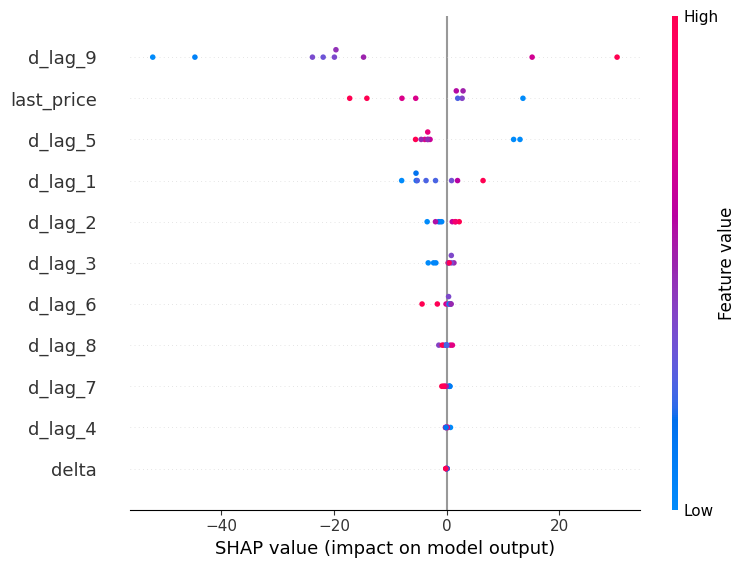

In [11]:
# Train/validation split
n = len(y_surr)
# Note: if the selected item has a short history, the surrogate dataset can be small.
# The surrogate (and SHAP) will still run, but interpret results cautiously.
if n < 200:
    print(f"⚠️ Warning: surrogate dataset is small (n={n}). "
          "Consider choosing an item with longer history or expanding the date range for more stable SHAP results.")
idx = np.arange(n)
np.random.shuffle(idx)
split = int(0.85 * n)

tr_idx, va_idx = idx[:split], idx[split:]
X_tr, y_tr = X_surr[tr_idx], y_surr[tr_idx]
X_va, y_va = X_surr[va_idx], y_surr[va_idx]

surrogate = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42
)
surrogate.fit(X_tr, y_tr)

pred_va = surrogate.predict(X_va)
mae = np.mean(np.abs(pred_va - y_va))
rmse = np.sqrt(np.mean((pred_va - y_va) ** 2))
print(f"Surrogate fidelity (teacher=transformer next-step): MAE={mae:.4f} | RMSE={rmse:.4f}")

# SHAP (TreeExplainer)
shap.initjs()

bg_n = min(SHAP_BACKGROUND_SIZE, len(X_tr))
background = X_tr[np.random.choice(len(X_tr), size=bg_n, replace=False)]

explainer = shap.TreeExplainer(surrogate, data=background)

ex_n = min(SHAP_EXPLAIN_SAMPLES, len(X_va))
X_explain = X_va[:ex_n]
shap_values = explainer.shap_values(X_explain)

shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=True)


In [12]:
# --- Surrogate fidelity table (held-out split): overall + per intervention δ ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

# meta holds (delta_pct, t_index) for each surrogate sample
va_meta = meta.iloc[va_idx].copy().reset_index(drop=True)
va_meta["y_true"] = y_va
va_meta["y_pred"] = pred_va

rows = []
# Overall
rows.append({
    "delta_pct": "All",
    "n_test": int(len(va_meta)),
    "MAE_test": float(mean_absolute_error(va_meta["y_true"], va_meta["y_pred"])),
    "RMSE_test": float(np.sqrt(mean_squared_error(va_meta["y_true"], va_meta["y_pred"])))
})

# Per intervention level
for d, g in va_meta.groupby("delta_pct"):
    rows.append({
        "delta_pct": float(d),
        "n_test": int(len(g)),
        "MAE_test": float(mean_absolute_error(g["y_true"], g["y_pred"])),
        "RMSE_test": float(np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])))
    })

fidelity_df = pd.DataFrame(rows)

# Sort: keep 'All' on top, then numeric deltas
fidelity_df["__sort__"] = fidelity_df["delta_pct"].apply(lambda x: -1e9 if x=="All" else float(x))
fidelity_df = fidelity_df.sort_values("__sort__").drop(columns="__sort__").reset_index(drop=True)

print("Surrogate fidelity on held-out samples (teacher = transformer next-step):")
display(fidelity_df)

# Optional export for copy/paste into Word
fidelity_df.to_csv("outputs_x_tbwisa/surrogate_fidelity_table.csv", index=False)
print("Saved: surrogate_fidelity_table.csv")


Surrogate fidelity on held-out samples (teacher = transformer next-step):


,delta_pct,n_test,MAE_test,RMSE_test
0,All,9,9.107293,12.969629
1,-15.0,1,4.067474,4.067474
2,-10.0,2,3.676941,4.878750
3,-5.0,1,6.805695,6.805695
4,5.0,1,1.295197,1.295197
5,10.0,2,11.995529,13.632530
6,15.0,2,19.226166,22.694340


Saved: surrogate_fidelity_table.csv


#### 5.3 Local SHAP per intervention (decision-point window)

Surrogate predicted next-step demand @ delta=-15%: 448.1469421386719


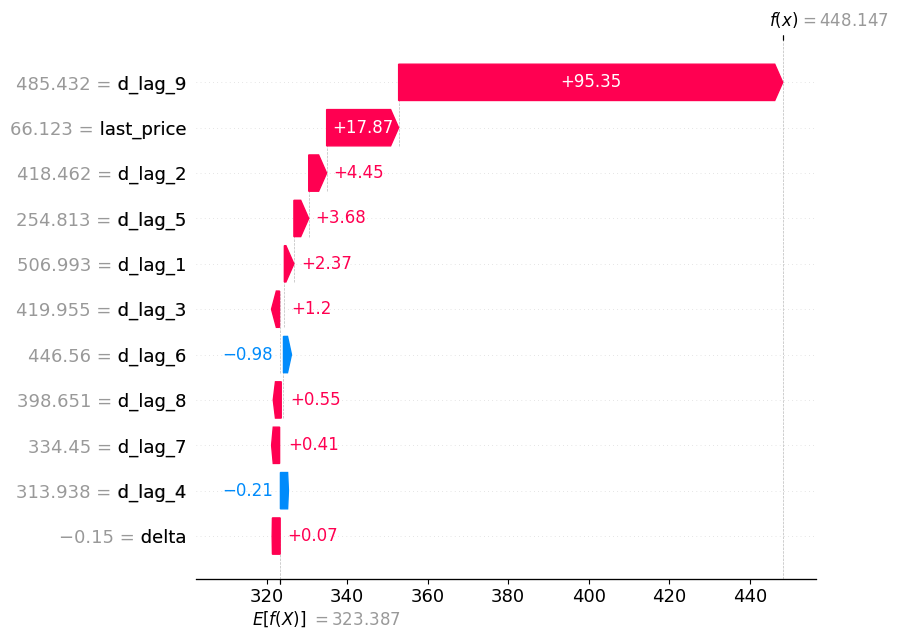

In [13]:
def last_window_features_for_delta(
    scenarios_input_raw: dict,
    scenarios_output_raw: dict,
    delta: float,
    seq_len: int
) -> np.ndarray:
    sname = f"{input_col} change {delta}%"
    d_s = np.asarray(scenarios_output_raw[sname], dtype=np.float32).reshape(-1)
    p_s = np.asarray((scenarios_input_raw[sname].values if hasattr(scenarios_input_raw[sname], 'values') else scenarios_input_raw[sname]),
                     dtype=np.float32).reshape(-1)

    # use surrogate feature length (not necessarily transformer.sequence_length)
    window = d_s[-seq_len:]
    last_price = float(p_s[-1])

    feats = np.concatenate([window, [delta/100.0, last_price]]).astype(np.float32)
    return feats.reshape(1, -1)


local_shap = {}
local_pred = {}

for delta in sorted(price_change_percentages):
    sname = f"{input_col} change {delta}%"
    if sname not in scenarios_output_raw:
        continue

    x_loc = last_window_features_for_delta(scenarios_input_raw, scenarios_output_raw, delta, SURROGATE_SEQ_LEN)
    sv = explainer.shap_values(x_loc)[0]
    local_shap[delta] = sv
    local_pred[delta] = float(surrogate.predict(x_loc)[0])

# Waterfall for a chosen delta
DELTA_TO_VIEW = price_change_percentages[0]
x_loc = last_window_features_for_delta(scenarios_input_raw, scenarios_output_raw, DELTA_TO_VIEW, SURROGATE_SEQ_LEN)
sv = explainer.shap_values(x_loc)[0]

base_value = explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0]
exp = shap.Explanation(values=sv, base_values=base_value, data=x_loc[0], feature_names=feature_names)

print(f"Surrogate predicted next-step demand @ delta={DELTA_TO_VIEW}%:", local_pred[DELTA_TO_VIEW])
shap.plots.waterfall(exp, max_display=18)


In [14]:
# --- SHAP drift computation from existing local SHAP vectors (Equation 9) ---
import numpy as np

# local_shap is computed above as: {delta: full SHAP vector at the decision point}
if 'shap_vectors' in globals():
    _shap_vecs = shap_vectors
elif 'local_shap' in globals():
    _shap_vecs = local_shap
else:
    raise NameError('Neither shap_vectors nor local_shap is defined. Ensure local SHAP values are computed before this cell.')

sorted_deltas = sorted(_shap_vecs.keys())
shap_drift_values = []
shap_drift_by_pair = {}

for d1, d2 in zip(sorted_deltas[:-1], sorted_deltas[1:]):
    phi_1 = np.asarray(_shap_vecs[d1], dtype=float).reshape(-1)
    phi_2 = np.asarray(_shap_vecs[d2], dtype=float).reshape(-1)
    drift = np.linalg.norm(phi_2 - phi_1, ord=1) / (np.linalg.norm(phi_1, ord=1) + 1e-8)
    shap_drift_values.append(drift)
    shap_drift_by_pair[(d1, d2)] = drift

# Empirical drift threshold (75th percentile) used for accept/flag screening
tau_drift = float(np.percentile(shap_drift_values, 75))
print(f'SHAP drift threshold (tau_drift, 75th percentile): {tau_drift:.4f}')


SHAP drift threshold (tau_drift, 75th percentile): 0.5710


#### 5.4 Integrated Gradients on the transformer (next-step attribution over lags)

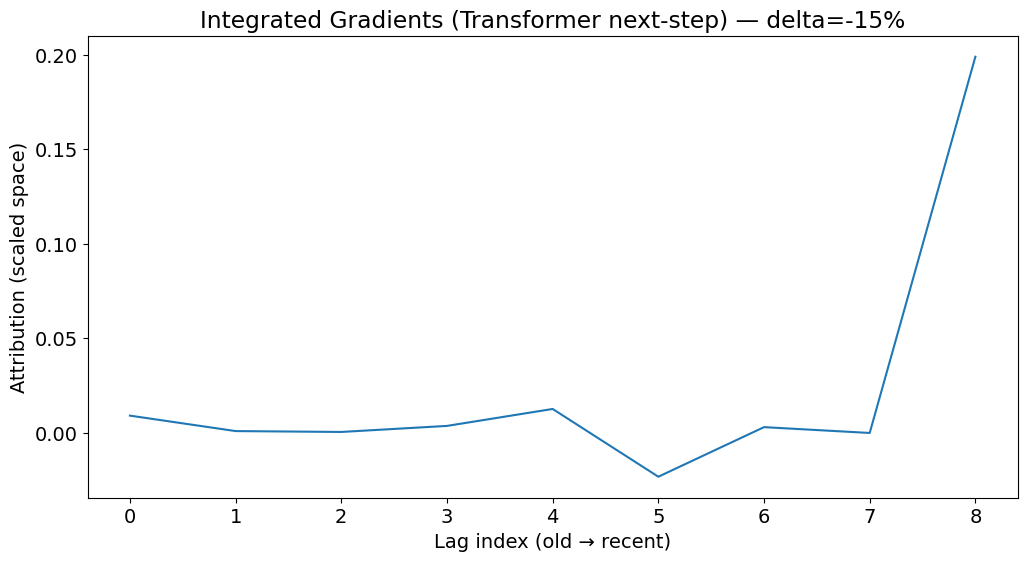

In [15]:
def integrated_gradients_next_step(
    model: ImprovedTransformerForecasting,
    window_raw: np.ndarray,
    baseline_raw: np.ndarray = None,
    steps: int = 64
) -> np.ndarray:
    """Integrated Gradients attribution for transformer next-step prediction w.r.t. input lags.

    Returns an attribution vector of length = len(window_raw) (before padding/truncation for the model).
    """
    window_raw = np.asarray(window_raw, dtype=np.float32).reshape(-1)
    if window_raw.size == 0:
        raise ValueError("Empty window provided.")

    if baseline_raw is None:
        baseline_raw = np.full_like(window_raw, np.mean(window_raw), dtype=np.float32)
    else:
        baseline_raw = np.asarray(baseline_raw, dtype=np.float32).reshape(-1)
        if baseline_raw.size != window_raw.size:
            baseline_raw = np.full_like(window_raw, np.mean(baseline_raw), dtype=np.float32)

    # We compute IG in the same length as the provided window, then pad/truncate to run the model
    # by embedding window in the model's expected seq_len.
    w = prep_window_for_model(model, window_raw)
    b = prep_window_for_model(model, baseline_raw)

    w_scaled = model.scaler.transform(w.reshape(-1,1)).astype(np.float32)
    b_scaled = model.scaler.transform(b.reshape(-1,1)).astype(np.float32)

    x = tf.convert_to_tensor(w_scaled.reshape(1, w_scaled.shape[0], 1))
    x0 = tf.convert_to_tensor(b_scaled.reshape(1, b_scaled.shape[0], 1))

    alphas = tf.linspace(0.0, 1.0, steps)
    total_grads = tf.zeros_like(x)

    for a in alphas:
        xi = x0 + a * (x - x0)
        with tf.GradientTape() as tape:
            tape.watch(xi)
            y = model.model(xi, training=False)  # (1,1)
        grads = tape.gradient(y, xi)
        total_grads += grads

    avg_grads = total_grads / tf.cast(steps, tf.float32)
    ig_scaled = (x - x0) * avg_grads  # (1, seq_len_model, 1)
    ig_scaled = ig_scaled.numpy().reshape(-1)

    # Map back to the original window length by taking the last len(window_raw) positions
    # (because we pad at the beginning).
    return ig_scaled[-len(window_raw):]

# Example IG on last window for a delta (use surrogate seq len for consistency)
DELTA_TO_VIEW = price_change_percentages[0]
sname = f"{input_col} change {DELTA_TO_VIEW}%"
d_s = np.asarray(scenarios_output_raw[sname], dtype=np.float32).reshape(-1)
window = d_s[-SURROGATE_SEQ_LEN:]

ig = integrated_gradients_next_step(model_output, window, steps=64)

plt.figure()
plt.plot(ig)
plt.title(f"Integrated Gradients (Transformer next-step) — delta={DELTA_TO_VIEW}%")
plt.xlabel("Lag index (old → recent)")
plt.ylabel("Attribution (scaled space)")
plt.show()


---
### 6. Explanation Robustness vs. Monotonicity & Economic Plausibility
#### 6.1 Scenario-level monotonicity and economic plausibility (forecast outcomes)

In [16]:
def forecast_slice_after_last_actual(df_forecast: pd.DataFrame, last_actual_ts: pd.Timestamp) -> np.ndarray:
    """Extract forecast-only values (exclude the inserted last-actual point)."""
    out = df_forecast[df_forecast.index > last_actual_ts].iloc[:, 0].values.astype(np.float32)
    return out

def compute_monotonicity_and_plausibility(
    scenarios_input: dict,
    scenarios_output: dict,
    deltas: list,
    last_actual_ts: pd.Timestamp
) -> pd.DataFrame:
    rows = []
    for delta in sorted(deltas):
        key = f"{input_col} change {delta}%"
        if key not in scenarios_output or key not in scenarios_input:
            continue

        p = forecast_slice_after_last_actual(scenarios_input[key], last_actual_ts)
        d = forecast_slice_after_last_actual(scenarios_output[key], last_actual_ts)

        mean_d = float(np.mean(d)) if len(d) else np.nan
        mean_p = float(np.mean(p)) if len(p) else np.nan

        # Economic plausibility: price-demand correlation should be negative (over horizon)
        if len(p) >= 2 and len(d) >= 2:
            corr = float(np.corrcoef(p, d)[0, 1])
        else:
            corr = np.nan

        rows.append({"delta_pct": delta, "mean_price": mean_p, "mean_demand": mean_d, "price_demand_corr": corr})

    out = pd.DataFrame(rows).sort_values("delta_pct").reset_index(drop=True)

    # Monotonicity consistency across adjacent deltas:
    # Expect demand to decrease as delta (price change) increases.
    sat = []
    for i in range(len(out) - 1):
        d1 = out.loc[i, "mean_demand"]
        d2 = out.loc[i+1, "mean_demand"]
        sat.append(bool(d1 >= d2))
    out["monotonicity_ok_next"] = [*sat, np.nan]

    # Plausibility binary
    out["economic_plausible"] = out["price_demand_corr"] < 0

    return out

last_ts = data.index[-1]
metrics_df = compute_monotonicity_and_plausibility(
    scenarios_input=scenarios_input,
    scenarios_output=scenarios_output,
    deltas=price_change_percentages,
    last_actual_ts=last_ts
)

display(metrics_df)
print("Monotonicity consistency (adjacent):", np.nanmean(metrics_df["monotonicity_ok_next"].values))
print("Economic plausibility (corr<0):", np.mean(metrics_df["economic_plausible"].values))


,delta_pct,mean_price,mean_demand,price_demand_corr,monotonicity_ok_next,economic_plausible
0,-15,88.681282,345.038666,-0.994700,True,True
1,-10,88.734062,340.324860,-0.996003,True,True
2,-5,88.967308,334.240570,-0.995667,True,True
3,5,92.103844,324.665375,-0.963621,True,True
4,10,94.444519,320.513824,-0.898241,True,True
5,15,96.777374,317.729370,-0.719425,NaN,True


Monotonicity consistency (adjacent): 1.0
Economic plausibility (corr<0): 1.0


#### 6.2 Explanation stability across adjacent deltas (SHAP)

In [17]:
def normalized_l1(v: np.ndarray) -> float:
    v = np.asarray(v, dtype=np.float32)
    denom = float(np.sum(np.abs(v))) + 1e-9
    return float(np.sum(np.abs(v))) / denom

def shap_adjacent_distances(local_shap: dict, feature_names: list, exclude_lags: bool = False) -> pd.DataFrame:
    deltas_sorted = sorted(local_shap.keys())

    rows = []
    for i in range(len(deltas_sorted) - 1):
        d1, d2 = deltas_sorted[i], deltas_sorted[i+1]

        v1 = np.asarray(local_shap[d1], dtype=np.float32).copy()
        v2 = np.asarray(local_shap[d2], dtype=np.float32).copy()

        if exclude_lags:
            # keep only controls: delta + last_price
            v1 = v1[-2:]
            v2 = v2[-2:]

        # Normalize by L1 magnitude to compare patterns
        v1 = v1 / (np.sum(np.abs(v1)) + 1e-9)
        v2 = v2 / (np.sum(np.abs(v2)) + 1e-9)

        dist = float(np.sum(np.abs(v1 - v2)))
        rows.append({"delta_from": d1, "delta_to": d2, "shap_dist_l1": dist})

    return pd.DataFrame(rows)

dist_full = shap_adjacent_distances(local_shap, feature_names, exclude_lags=False)
dist_ctrl = shap_adjacent_distances(local_shap, feature_names, exclude_lags=True)

display(dist_full, dist_ctrl)


,delta_from,delta_to,shap_dist_l1
0,-15,-10,0.058555
1,-10,-5,0.193307
2,-5,5,0.454724
3,5,10,0.352563
4,10,15,1.152654


,delta_from,delta_to,shap_dist_l1
0,-15,-10,0.002491
1,-10,-5,0.006525
2,-5,5,0.173371
3,5,10,0.557865
4,10,15,1.974993


#### 6.3 Economic alignment check on SHAP(delta)

In [18]:
def shap_delta_alignment_violations(local_shap: dict, feature_names: list, tol: float = 0.0) -> pd.DataFrame:
    """Check sign consistency on SHAP(delta) for demand:
       - delta > 0 => SHAP(delta) should be <= 0
       - delta < 0 => SHAP(delta) should be >= 0
    """
    delta_idx = feature_names.index("delta")
    rows = []
    for d, sv in local_shap.items():
        val = float(sv[delta_idx])
        ok = True
        if d > 0 and val > tol:
            ok = False
        if d < 0 and val < -tol:
            ok = False
        rows.append({"delta_pct": d, "shap_delta": val, "alignment_ok": ok})
    return pd.DataFrame(rows).sort_values("delta_pct")

align_df = shap_delta_alignment_violations(local_shap, feature_names, tol=0.0)
display(align_df)
print("Alignment OK rate:", align_df["alignment_ok"].mean())


,delta_pct,shap_delta,alignment_ok
0,-15,0.065581,True
1,-10,0.065351,True
2,-5,0.112153,True
3,5,0.256429,False
4,10,-0.378465,True
5,15,-0.112713,True


Alignment OK rate: 0.8333333333333334


#### 6.4 Plots: explainability robustness vs monotonicity/economic plausibility

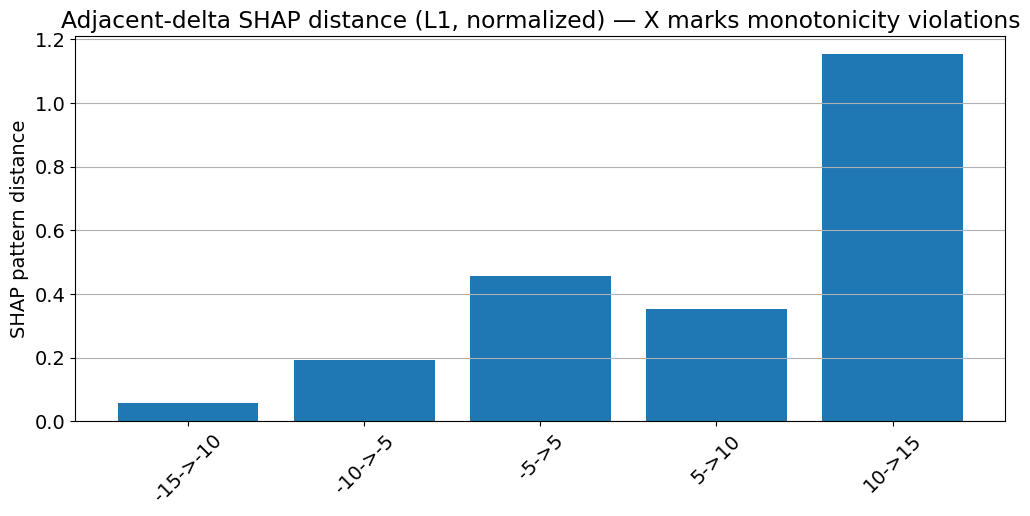

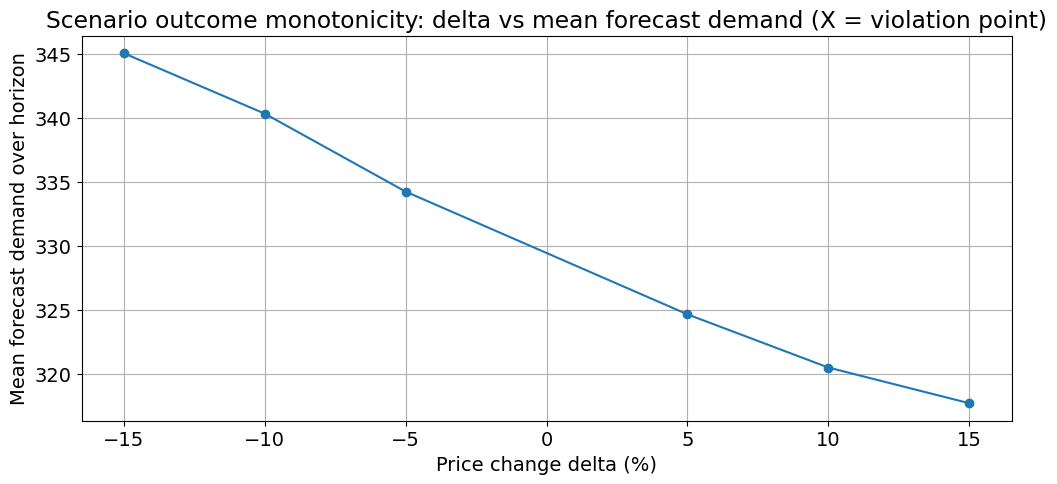

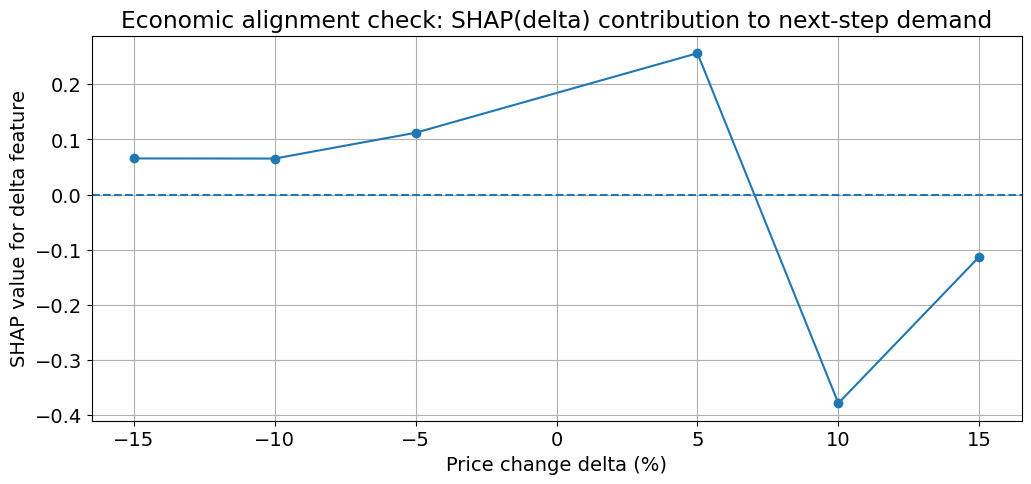

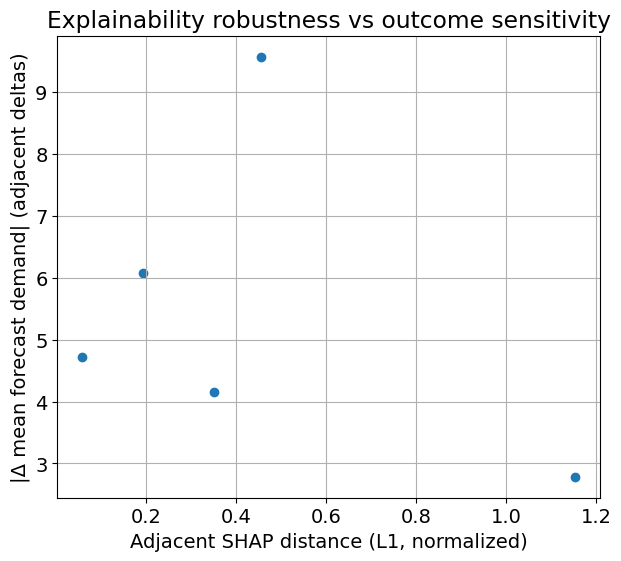

In [19]:
# Merge adjacent SHAP distances with scenario outcome monotonicity flags
m = metrics_df.copy()
d = dist_full.copy()

# outcome monotonicity for pair (delta_from -> delta_to) is at row delta_from
pair = d.merge(m[["delta_pct", "monotonicity_ok_next"]], left_on="delta_from", right_on="delta_pct", how="left")
pair.drop(columns=["delta_pct"], inplace=True)

plt.figure(figsize=(12, 5))
plt.bar(range(len(pair)), pair["shap_dist_l1"].values)
for i, ok in enumerate(pair["monotonicity_ok_next"].values):
    if ok is False:
        plt.scatter(i, pair["shap_dist_l1"].values[i], s=120, marker="x")  # mark violations
plt.xticks(range(len(pair)), [f"{a}->{b}" for a,b in zip(pair["delta_from"], pair["delta_to"])], rotation=45)
plt.title("Adjacent-delta SHAP distance (L1, normalized) — X marks monotonicity violations")
plt.ylabel("SHAP pattern distance")
plt.grid(True, axis="y")
plt.show()

# Delta vs mean forecast demand and plausibility
plt.figure(figsize=(12, 5))
plt.plot(metrics_df["delta_pct"], metrics_df["mean_demand"], marker="o")
for i in range(len(metrics_df)-1):
    if metrics_df.loc[i, "monotonicity_ok_next"] is False:
        plt.scatter(metrics_df.loc[i+1, "delta_pct"], metrics_df.loc[i+1, "mean_demand"], s=120, marker="x")
plt.title("Scenario outcome monotonicity: delta vs mean forecast demand (X = violation point)")
plt.xlabel("Price change delta (%)")
plt.ylabel("Mean forecast demand over horizon")
plt.grid(True)
plt.show()

# SHAP(delta) vs delta
plt.figure(figsize=(12, 5))
plt.plot(align_df["delta_pct"], align_df["shap_delta"], marker="o")
plt.axhline(0, linestyle="--")
plt.title("Economic alignment check: SHAP(delta) contribution to next-step demand")
plt.xlabel("Price change delta (%)")
plt.ylabel("SHAP value for delta feature")
plt.grid(True)
plt.show()

# Scatter: SHAP distance vs |mean demand change| (adjacent pairs)
pair2 = pair.merge(
    m[["delta_pct", "mean_demand"]], left_on="delta_from", right_on="delta_pct", how="left"
).rename(columns={"mean_demand":"mean_demand_from"}).drop(columns=["delta_pct"])
pair2 = pair2.merge(
    m[["delta_pct", "mean_demand"]], left_on="delta_to", right_on="delta_pct", how="left"
).rename(columns={"mean_demand":"mean_demand_to"}).drop(columns=["delta_pct"])
pair2["abs_mean_demand_diff"] = np.abs(pair2["mean_demand_from"] - pair2["mean_demand_to"])

plt.figure(figsize=(7, 6))
plt.scatter(pair2["shap_dist_l1"], pair2["abs_mean_demand_diff"])
plt.title("Explainability robustness vs outcome sensitivity")
plt.xlabel("Adjacent SHAP distance (L1, normalized)")
plt.ylabel("|Δ mean forecast demand| (adjacent deltas)")
plt.grid(True)
plt.show()


#### 6.5 Decision policy

In [20]:
def decision_screening(shap_drift, drift_threshold, monotonicity_ok, economic_ok):
    """Return ACCEPT or FLAG for a recommended scenario–window pair.

    Policy used in the thesis/article version:
    - FLAG if monotonicity_ok or economic_ok fail (screening rules).
    - FLAG if adjacent-intervention SHAP drift is at or above drift_threshold (Eq. 9).
    - price_feature_drift_ratio is reported for analysis, but does not gate the decision.
    """
    if (not monotonicity_ok) or (not economic_ok):
        return "FLAG"
    if shap_drift >= drift_threshold:
        return "FLAG"
    return "ACCEPT"


In [21]:
# --- Summary: ACCEPT/FLAG decisions for all delta scenarios (article-ready) ---

# Required artifacts
required = ["local_shap", "shap_drift_by_pair", "tau_drift", "metrics_df", "align_df", "feature_names"]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(
        "Missing required variables for all-scenarios summary: "
        + ", ".join(missing)
        + ". Run previous sections before this cell."
    )

def _adjacent_pair_for_delta(delta, sorted_deltas):
    # Return (delta_from, delta_to) as an adjacent pair used for drift screening
    idx = sorted_deltas.index(delta)
    if idx < len(sorted_deltas) - 1:
        return delta, sorted_deltas[idx + 1]
    return sorted_deltas[idx - 1], delta  # last delta uses previous pair

def _get_drift(delta_from, delta_to):
    key = (delta_from, delta_to)
    if key in shap_drift_by_pair:
        return float(shap_drift_by_pair[key])
    # fallback compute from local_shap
    v1 = np.asarray(local_shap[delta_from], dtype=float).reshape(-1)
    v2 = np.asarray(local_shap[delta_to], dtype=float).reshape(-1)
    return float(np.linalg.norm(v2 - v1, ord=1) / (np.linalg.norm(v1, ord=1) + 1e-8))

def _bool_from_df(df, key_col, key_val, val_col, default=True):
    s = df.loc[df[key_col] == key_val, val_col]
    if len(s) == 0 or pd.isna(s.iloc[0]):
        return default
    return bool(s.iloc[0])

def _price_drift_ratio(delta_from, delta_to):
    try:
        price_idx = [feature_names.index("delta"), feature_names.index("last_price")]
        v1 = np.asarray(local_shap[delta_from], dtype=float).reshape(-1)
        v2 = np.asarray(local_shap[delta_to], dtype=float).reshape(-1)
        diff = np.abs(v2 - v1)
        return float(diff[price_idx].sum() / (diff.sum() + 1e-8))
    except Exception:
        return None

# Build decisions over all deltas available in local_shap
sorted_deltas = sorted(local_shap.keys())

rows = []
for delta in sorted_deltas:
    delta_from, delta_to = _adjacent_pair_for_delta(delta, sorted_deltas)
    drift = _get_drift(delta_from, delta_to)

    # monotonicity for the adjacent transition is stored on the "from" delta row
    monotonicity_ok = _bool_from_df(metrics_df, "delta_pct", delta_from, "monotonicity_ok_next", default=True)

    # economic checks for this delta
    economic_plausible = _bool_from_df(metrics_df, "delta_pct", float(delta), "economic_plausible", default=True)
    alignment_ok = _bool_from_df(align_df, "delta_pct", float(delta), "alignment_ok", default=True)
    economic_ok = bool(economic_plausible and alignment_ok)

    # optional drift localization
    price_ratio = _price_drift_ratio(delta_from, delta_to)

    decision = decision_screening(
        shap_drift=drift,
        drift_threshold=float(tau_drift),
        monotonicity_ok=monotonicity_ok,
        economic_ok=economic_ok,
    )

    # reason tag (useful for writing the paper)
    if (not monotonicity_ok) or (not economic_ok):
        reason = "Economic/monotonicity"
    elif drift >= float(tau_drift):
        reason = "High SHAP drift"
    else:
        reason = "—"

    # Optional: compute per-scenario optimal window if TBWISA objects are available
    win_start = win_end = win_score = None
    scenario_name = f"{input_col} change {delta}%"
    if ("scenario_generator" in globals()) and ("scenarios_result" in globals()) and ("scenarios_output" in globals()):
        # try to map to an existing scenario name
        for name in scenarios_result.keys():
            m = re.search(r"change\s*([+-]?\d+(?:\.\d+)?)\s*%", str(name))
            if m and float(m.group(1)) == float(delta):
                scenario_name = name
                break
        if scenario_name in scenarios_result and scenario_name in scenarios_output:
            single_rev = {scenario_name: scenarios_result[scenario_name]}
            single_dem = {scenario_name: scenarios_output[scenario_name]}
            tmp = scenario_generator.find_optimal_window_with_demand(
                single_rev,
                single_dem,
                penalty_factor=0.1,
                demand_weight=1.5,
                min_window_size=min_window_size,
                max_window_size=max_window_size
            )
            win_start, win_end, win_score = tmp.get("start"), tmp.get("end"), tmp.get("score")

    rows.append({
        "scenario": scenario_name,
        "delta_pct": float(delta),
        "window_start": win_start,
        "window_end": win_end,
        "window_score": float(win_score) if win_score is not None else None,
        "adjacent_pair": f"{delta_from} → {delta_to}",
        "D_SHAP": drift,
        "tau_drift": float(tau_drift),
        "monotonicity_ok": monotonicity_ok,
        "economic_plausible": economic_plausible,
        "alignment_ok": alignment_ok,
        "economic_ok": economic_ok,
        "price_feature_drift_ratio": price_ratio,
        "decision": decision,
        "reason": reason,
    })

decisions_df = pd.DataFrame(rows)

# Data-driven threshold for price-dominated drift (auxiliary diagnostic)
_ratio_series = decisions_df["price_feature_drift_ratio"].dropna()
if len(_ratio_series) > 0:
    price_drift_threshold_data = float(np.percentile(_ratio_series.values, 75))
else:
    price_drift_threshold_data = None

# Append "(price-dominated)" to drift-related reasons when ratio exceeds the threshold
if price_drift_threshold_data is not None:
    _mask = (
        decisions_df["price_feature_drift_ratio"].notna()
        & (decisions_df["price_feature_drift_ratio"] >= price_drift_threshold_data)
        & decisions_df["reason"].astype(str).str.contains("High SHAP drift", regex=False)
    )
    decisions_df.loc[_mask, "reason"] = decisions_df.loc[_mask, "reason"].astype(str) + " (price-dominated)"


# Sort for presentation: flagged first, then by delta
decisions_df = decisions_df.sort_values(by=["decision", "delta_pct"], ascending=[True, True]).reset_index(drop=True)

print("Decision summary across all delta scenarios (ACCEPT/FLAG):")
if "price_drift_threshold_data" in globals() and price_drift_threshold_data is not None:
    print(f"Price-drift dominance threshold (p75 of ratios): {price_drift_threshold_data:.4f}")
display(decisions_df)

# Convenience counts (for article text)
print("\nCounts:")
print(decisions_df["decision"].value_counts())

Decision summary across all delta scenarios (ACCEPT/FLAG):
Price-drift dominance threshold (p75 of ratios): 0.2169


,scenario,delta_pct,window_start,window_end,window_score,adjacent_pair,D_SHAP,tau_drift,monotonicity_ok,economic_plausible,alignment_ok,economic_ok,price_feature_drift_ratio,decision,reason
0,price change -15%,-15.0,1,2,35244.309821,-15 → -10,0.164395,0.570971,True,True,True,True,0.220287,ACCEPT,—
1,price change -10%,-10.0,1,2,34003.961267,-10 → -5,0.260838,0.570971,True,True,True,True,0.014074,ACCEPT,—
2,price change -5%,-5.0,1,2,32602.785817,-5 → 5,0.570971,0.570971,True,True,True,True,0.224137,FLAG,High SHAP drift (price-dominated)
3,price change 5%,5.0,1,2,31690.355349,5 → 10,0.463127,0.570971,True,True,False,False,0.093431,FLAG,Economic/monotonicity
4,price change 10%,10.0,2,3,31644.308064,10 → 15,1.614188,0.570971,True,True,True,True,0.206620,FLAG,High SHAP drift
5,price change 15%,15.0,3,4,31862.550831,10 → 15,1.614188,0.570971,True,True,True,True,0.206620,FLAG,High SHAP drift



Counts:
decision
FLAG      4
ACCEPT    2
Name: count, dtype: int64


---
### 7. Save artifacts (optional)

In [22]:
# Save tables for paper / appendix usage
out_dir = "outputs_x_tbwisa"
os.makedirs(out_dir, exist_ok=True)

metrics_df.to_csv(os.path.join(out_dir, f"metrics_{dataset_name}_{item_id}_{store_id}.csv"), index=False)
dist_full.to_csv(os.path.join(out_dir, f"shap_stability_full_{dataset_name}_{item_id}_{store_id}.csv"), index=False)
align_df.to_csv(os.path.join(out_dir, f"shap_delta_alignment_{dataset_name}_{item_id}_{store_id}.csv"), index=False)

print("Saved to:", out_dir)


Saved to: outputs_x_tbwisa
